In [12]:
import pandas as pd
import numpy as np


from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


import statsmodels.api as sm
import statsmodels.formula.api as smf

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


import xgboost as xgb

import skforecast
import sklearn
from xgboost import XGBRegressor
from sklearn.feature_selection import RFECV
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import bayesian_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import select_features
import shap


In [3]:
df = pd.read_csv(r'C:\Users\whiter04\OneDrive - Johnson Matthey\00. cspark\ELY\ELY-TimeSeries\Data\master_data_frame.csv')
df_copy = df.copy()
df_copy = df_copy.drop('Unnamed: 0',axis=1) 
df_copy


to_drop = ['temp_anode_inlet_set', 
           'temp_cathode_inlet_set', 
           'pressure_anode_set',
           'pressure_cathode_set', 
           'flow_anode_di_water_supply_set', 
           'flow_cathode_di_water_supply_set', 
          'flow_cathode_di_water_supply', 
           'signal_in_o2_in_h2_sensor']

df_copy = df_copy.drop(to_drop, axis=1)
df_copy


df_copy['seconds'] = (df_copy['time_running_total']/1000).astype(int)
df_copy['minutes'] = (df_copy['seconds']/60).astype(int)

# df_copy['hours'] = (df_copy['minutes']/60).astype(int)
# df_copy['days'] = (df_copy['hours']/24).astype(int)
# df_copy['weeks'] = (df_copy['days']/7).astype(int)
df_copy = df_copy.drop('time_running_total',axis=1)

# df_copy = df_copy.tail(150000)
df_copy

numexpr.utils INFO  NumExpr defaulting to 8 threads.


,cell_voltage_001,current,current_density,temp_anode_inlet,temp_anode_outlet,temp_cathode_inlet,temp_cathode_outlet,pressure_anode_inlet,pressure_anode_outlet,pressure_cathode_inlet,pressure_cathode_outlet,flow_anode_di_water_supply,signal_in_resistivity_anode,signal_in_resistivity_cathode,signal_in_h2_in_o2_sensor,seconds,minutes
0,-0.095167,-0.01262,-0.000505,22.524658,22.211363,22.943993,22.664978,0.015911,-0.026205,-0.009285,-0.009439,0.149858,0.142337,0.580925,0.278146,0,0
1,-0.095167,-0.01262,-0.000505,22.524658,22.211363,22.943993,22.664978,0.015911,-0.026205,-0.009285,-0.009439,0.149858,0.142337,0.580925,0.278146,0,0
2,-0.095167,-0.01262,-0.000505,22.524658,22.211363,22.943993,22.664978,0.015911,-0.026205,-0.009285,-0.009439,0.149858,0.142337,0.580925,0.278146,0,0
3,-0.095167,-0.01192,-0.000477,23.574999,22.622944,22.930300,22.651320,0.184089,-0.026205,-0.009285,-0.001021,0.270174,0.132591,0.585798,0.276583,30,0
4,-0.095167,-0.01192,-0.000477,23.574999,22.622944,22.930300,22.651320,0.184089,-0.026205,-0.009285,-0.001021,0.270174,0.132591,0.585798,0.276583,30,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
461237,1.879790,75.00482,3.000193,79.819145,78.329117,29.627552,34.574463,1.992006,1.723834,6.002450,6.019177,0.300858,0.230055,0.152083,0.104703,4934550,82242
461238,1.879790,75.00482,3.000193,79.819145,78.329117,29.627552,34.574463,1.992006,1.723834,6.002450,6.019177,0.300858,0.230055,0.152083,0.104703,4934550,82242
461239,1.880171,75.00482,2.999912,79.819145,78.354111,29.627552,34.560806,1.992006,1.723834,6.002450,5.960248,0.300858,0.215435,0.156957,0.103140,4934580,82243
461240,1.880171,75.00482,2.999912,79.819145,78.354111,29.627552,34.560806,1.992006,1.723834,6.002450,5.960248,0.300858,0.215435,0.156957,0.103140,4934580,82243


In [4]:
import matplotlib.pyplot as plt

time_period = 'minutes'

df_time = df_copy.groupby(time_period).mean().reset_index()

downsampled_df = df_time.tail(21000).reset_index()

downsampled_df = downsampled_df[['signal_in_h2_in_o2_sensor']]

# downsampled_df[time_period] = pd.to_datetime('2024-05-16 00:00:00') + pd.to_timedelta(downsampled_df[time_period], unit='m')



# plt.plot(downsampled_df['signal_in_h2_in_o2_sensor'])

# plt.show()

# downsampled_df = downsampled_df.set_index('minutes')
downsampled_df

,signal_in_h2_in_o2_sensor
0,0.241426
1,0.240645
2,0.242207
3,0.241426
4,0.240645
...,...
20995,0.101265
20996,0.103140
20997,0.103140
20998,0.103765


In [5]:

# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=20, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = pd.concat(cols, axis=1)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg.values


test = series_to_supervised(downsampled_df)


test = pd.DataFrame(test)

In [6]:
y = test.iloc[:,-1]
X = test.iloc[:,:-1]

X_train, X_test, y_train, y_test = train_test_split(X,y, shuffle=False, test_size=0.75)


In [7]:
from sklearn.model_selection import GridSearchCV


model_2 = XGBRegressor()

param_grid = {
    'max_depth': [2, 3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
    'subsample': [0.5, 0.7, 1],
    'n_estimators': [10,50,100,200]
}



gcv = GridSearchCV(estimator=model_2,
             param_grid=param_grid, 
                  verbose=2)


gcv.fit(X_train, y_train)



Fitting 5 folds for each of 144 candidates, totalling 720 fits
[CV] END learning_rate=0.1, max_depth=2, n_estimators=10, subsample=0.5; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=2, n_estimators=10, subsample=0.5; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=2, n_estimators=10, subsample=0.5; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=2, n_estimators=10, subsample=0.5; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=2, n_estimators=10, subsample=0.5; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=2, n_estimators=10, subsample=0.7; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=2, n_estimators=10, subsample=0.7; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=2, n_estimators=10, subsample=0.7; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=2, n_estimators=10, subsample=0.7; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=2, n_estimators=10, subsample=0.7; total time=   0.0s
[CV] END learning

[CV] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.5; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.5; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.5; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.5; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.5; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1

[CV] END learning_rate=0.1, max_depth=7, n_estimators=10, subsample=0.5; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=7, n_estimators=10, subsample=0.5; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=7, n_estimators=10, subsample=0.7; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=7, n_estimators=10, subsample=0.7; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=7, n_estimators=10, subsample=0.7; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=7, n_estimators=10, subsample=0.7; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=7, n_estimators=10, subsample=0.7; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=7, n_estimators=10, subsample=1; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=7, n_estimators=10, subsample=1; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=7, n_estimators=10, subsample=1; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=7, n_estimators=10, subsample=1; total time=   0

[CV] END learning_rate=0.01, max_depth=2, n_estimators=100, subsample=0.5; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=2, n_estimators=100, subsample=0.5; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=2, n_estimators=100, subsample=0.7; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=2, n_estimators=100, subsample=0.7; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=2, n_estimators=100, subsample=0.7; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=2, n_estimators=100, subsample=0.7; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=2, n_estimators=100, subsample=0.7; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=2, n_estimators=100, subsample=1; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=2, n_estimators=100, subsample=1; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=2, n_estimators=100, subsample=1; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=2, n_estimators=100, subsam

[CV] END learning_rate=0.01, max_depth=5, n_estimators=10, subsample=0.5; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=5, n_estimators=10, subsample=0.7; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=5, n_estimators=10, subsample=0.7; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=5, n_estimators=10, subsample=0.7; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=5, n_estimators=10, subsample=0.7; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=5, n_estimators=10, subsample=0.7; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=5, n_estimators=10, subsample=1; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=5, n_estimators=10, subsample=1; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=5, n_estimators=10, subsample=1; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=5, n_estimators=10, subsample=1; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=5, n_estimators=10, subsample=1; total 

[CV] END learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.5; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.5; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.7; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.7; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.7; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.7; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.7; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=7, n_estimators=100, subsample=1; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=7, n_estimators=100, subsample=1; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=7, n_estimators=100, subsample=1; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=7, n_estimators=100, subsam

[CV] END learning_rate=0.001, max_depth=3, n_estimators=10, subsample=0.7; total time=   0.0s
[CV] END learning_rate=0.001, max_depth=3, n_estimators=10, subsample=0.7; total time=   0.0s
[CV] END learning_rate=0.001, max_depth=3, n_estimators=10, subsample=0.7; total time=   0.0s
[CV] END learning_rate=0.001, max_depth=3, n_estimators=10, subsample=0.7; total time=   0.0s
[CV] END learning_rate=0.001, max_depth=3, n_estimators=10, subsample=0.7; total time=   0.0s
[CV] END learning_rate=0.001, max_depth=3, n_estimators=10, subsample=1; total time=   0.0s
[CV] END learning_rate=0.001, max_depth=3, n_estimators=10, subsample=1; total time=   0.0s
[CV] END learning_rate=0.001, max_depth=3, n_estimators=10, subsample=1; total time=   0.0s
[CV] END learning_rate=0.001, max_depth=3, n_estimators=10, subsample=1; total time=   0.0s
[CV] END learning_rate=0.001, max_depth=3, n_estimators=10, subsample=1; total time=   0.0s
[CV] END learning_rate=0.001, max_depth=3, n_estimators=50, subsample=

[CV] END learning_rate=0.001, max_depth=5, n_estimators=100, subsample=0.5; total time=   0.2s
[CV] END learning_rate=0.001, max_depth=5, n_estimators=100, subsample=0.5; total time=   0.2s
[CV] END learning_rate=0.001, max_depth=5, n_estimators=100, subsample=0.7; total time=   0.2s
[CV] END learning_rate=0.001, max_depth=5, n_estimators=100, subsample=0.7; total time=   0.2s
[CV] END learning_rate=0.001, max_depth=5, n_estimators=100, subsample=0.7; total time=   0.2s
[CV] END learning_rate=0.001, max_depth=5, n_estimators=100, subsample=0.7; total time=   0.2s
[CV] END learning_rate=0.001, max_depth=5, n_estimators=100, subsample=0.7; total time=   0.2s
[CV] END learning_rate=0.001, max_depth=5, n_estimators=100, subsample=1; total time=   0.2s
[CV] END learning_rate=0.001, max_depth=5, n_estimators=100, subsample=1; total time=   0.2s
[CV] END learning_rate=0.001, max_depth=5, n_estimators=100, subsample=1; total time=   0.2s
[CV] END learning_rate=0.001, max_depth=5, n_estimators=

GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bi...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth': [2, 3, 5, 7],
                         'n_estimators': [10, 50, 100, 200],
                         'subsample': [0.5, 0.7, 1]},
             verbose=2)

In [8]:
print(f'best_params_: {gcv.best_params_}')
new_model = gcv.best_estimator_



best_params_: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.5}


mse 5.2143278164584986e-05
RMSE: 0.0072210302702997295
Percentage RMSE: 4.548263338293454%
r2 0.9905018233678267


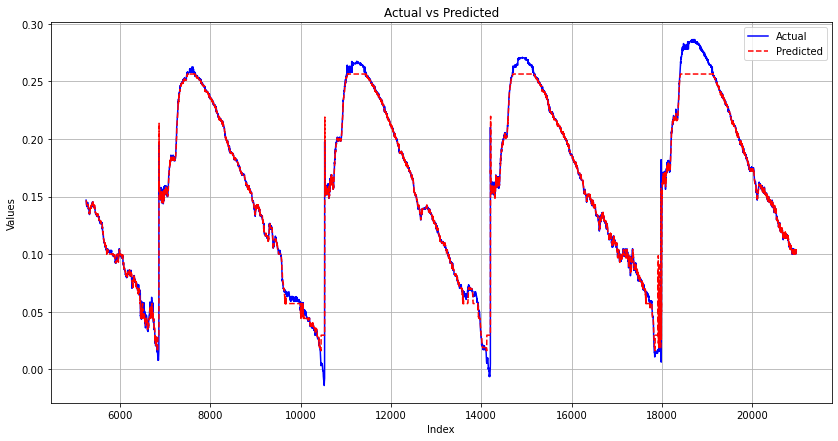

In [14]:
y_pred = new_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f'mse {mse}')






rmse = np.sqrt(mean_squared_error( y_test, y_pred))
print(f"RMSE: {rmse}")



percentage_rmse = (rmse / y_test.mean()) * 100
print(f"Percentage RMSE: {percentage_rmse}%")



r2 = r2_score(y_test, y_pred)
print(f'r2 {r2}')



# Plotting
plt.figure(figsize=(14, 7))
plt.plot(y_test.index, y_test, label='Actual', color='blue')
plt.plot(y_test.index, y_pred, label='Predicted', color='red', linestyle='--')
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.show()

In [55]:
from xgboost import cv


best_params = {'learning_rate': 0.1, 
               'max_depth': 3,
#                'n_estimators': 100, 
               'subsample': 1}


dtrain = xgb.DMatrix(data=X_train, label=y_train)


xgb_cv = cv(dtrain=dtrain, 
            params=best_params,
            nfold=5,
            num_boost_round=100,
            early_stopping_rounds=10, 
            metrics="rmse")





In [57]:
new_params = {'learning_rate': 0.1, 
               'max_depth': 3,
               'subsample': 1}

optimal_num_boost_round = 50


final_model = xgb.train(
    params=best_params,
    dtrain=dtrain,
    num_boost_round=optimal_num_boost_round
)


final_model


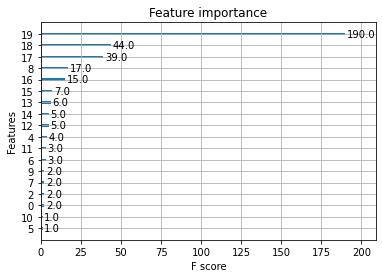

<Figure size 1152x864 with 0 Axes>

In [58]:
xgb.plot_importance(final_model)
plt.figure(figsize = (16, 12))
plt.show()

mse 4.951758570143467e-05
Percentage RMSE: 4.097045628264522%


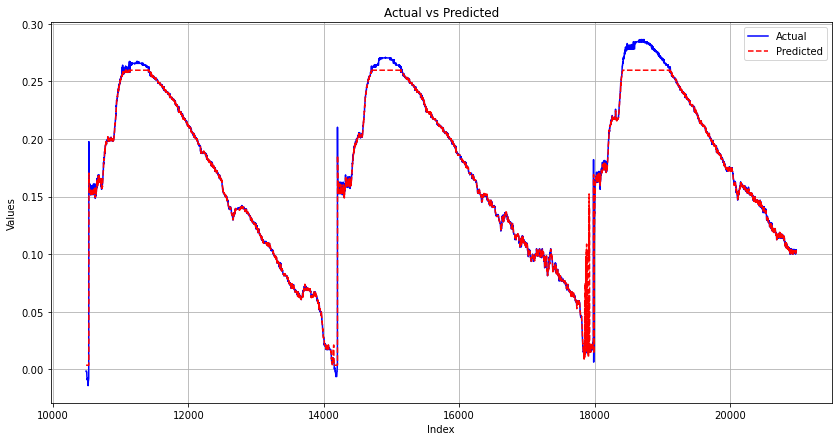

In [59]:
dtest= xgb.DMatrix(data=X_test, label=y_test)


y_pred = final_model.predict(dtest)

mse = mean_squared_error(y_test, y_pred)
print(f'mse {mse}')



rmse = np.sqrt(mean_squared_error( y_test, y_pred))
percentage_rmse = (rmse / y_test.mean()) * 100
print(f"Percentage RMSE: {percentage_rmse}%")







# Plotting
plt.figure(figsize=(14, 7))
plt.plot(y_test.index, y_test, label='Actual', color='blue')
plt.plot(y_test.index, y_pred_series, label='Predicted', color='red', linestyle='--')
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.show()

In [191]:
line = pd.DataFrame(X_train.iloc[n]).transpose()

preds = []
line_items = [line]

n=9000




for i in range(0,10):


#     line = pd.DataFrame(X_train.iloc[n]).transpose()

    dtest_1 = xgb.DMatrix(data=line)
    y_pred_recursive = final_model.predict(dtest_1)

    

    line.iloc[:, :-1] = line.iloc[:, 1:].values
    line = line.iloc[:, :-1]
    line[19] = y_pred_recursive[0]
    line
    
    preds.append( y_pred_recursive[0])
    line_items.append(line)
    
    print(line)
preds

            0         1         2         3         4         5         6   \
9000  0.135954  0.135954  0.135173  0.134391  0.134391  0.134391  0.134391   

            7         8         9         10        11        12        13  \
9000  0.133766  0.134391  0.133766  0.134391  0.132829  0.134391  0.134391   

            14        15        16        17        18        19  
9000  0.134391  0.134391  0.135016  0.135954  0.135954  0.135771  
            0         1         2         3         4         5         6   \
9000  0.135954  0.135173  0.134391  0.134391  0.134391  0.134391  0.133766   

            7         8         9         10        11        12        13  \
9000  0.134391  0.133766  0.134391  0.132829  0.134391  0.134391  0.134391   

            14        15        16        17        18        19  
9000  0.134391  0.135016  0.135954  0.135954  0.135771  0.135001  
            0         1         2         3         4         5         6   \
9000  0.135173  0.134391  

[0.1357712,
 0.13500068,
 0.13462675,
 0.13462675,
 0.13423803,
 0.13423803,
 0.1338626,
 0.1338626,
 0.1338626,
 0.1338626]